In [1]:
import time
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
#from statsmodels.tsa.vector_ar.var_model import VAR

import warnings
warnings.simplefilter('ignore')

plt.rcParams["figure.figsize"] = [40, 12]  # width, height
plt.rcParams['xtick.direction'] = 'out'

# 1. Load Data

In [2]:
df = pd.read_csv('./data/train.csv', usecols=['id', 'date', 'family', 'sales'], header=0)

In [3]:
print(df.shape)

(3000888, 4)


In [4]:
df.tail()

,id,date,family,sales
3000883,3000883,2017-08-15,POULTRY,438.133
3000884,3000884,2017-08-15,PREPARED FOODS,154.553
3000885,3000885,2017-08-15,PRODUCE,2419.729
3000886,3000886,2017-08-15,SCHOOL AND OFFICE SUPPLIES,121.000
3000887,3000887,2017-08-15,SEAFOOD,16.000


# 2. Preprocess Data

In [5]:
data = df.copy()

In [6]:
data['date'] = pd.to_datetime(data['date'], format = "%Y-%m-%d")

In [7]:
#1276 vs 45
df_train_mag_sales = data.loc[(data['family'] == 'MAGAZINES') & ((data['date'] >= '2014-01-01') & (data['date'] <= '2017-06-30'))].groupby(['date']).sum().copy()
df_train_mag_sales = df_train_mag_sales.loc[:, 'sales':'sales']

In [8]:
df_train_mag_sales.head(5)

,sales
date,
2014-01-01,1.0
2014-01-02,41.0
2014-01-03,24.0
2014-01-04,33.0
2014-01-05,23.0


In [9]:
data = df.copy()

In [10]:
data['date'] = pd.to_datetime(data['date'], format = "%Y-%m-%d")

In [11]:
df_test_mag_sales = data.loc[(data['family'] == 'MAGAZINES') & ((data['date'] >= '2017-07-1') & (data['date'] <= '2017-08-15'))].groupby(['date']).sum().copy()
df_test_mag_sales = df_test_mag_sales.loc[:, 'sales':'sales']

In [12]:
df_test_mag_sales.head(5)

,sales
date,
2017-07-01,292.0
2017-07-02,259.0
2017-07-03,167.0
2017-07-04,159.0
2017-07-05,160.0


# 3. Data Plot
- Extract MAGAZINES data from 2014-01-01 for training and prediction

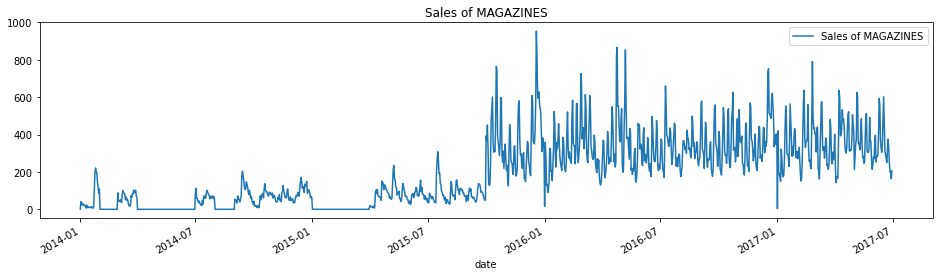

In [13]:
df_train_mag_sales["sales"].plot(figsize=(16,4),legend=True)
plt.legend(['Sales of MAGAZINES'])
plt.title('Sales of MAGAZINES')
plt.show()

# 4. Stationary Check - Adfuller Test
H0: The null hypothesis: It is a statement about the population that either is believed to be true or is used to put forth an argument unless it can be shown to be incorrect beyond a reasonable doubt.

H1: The alternative hypothesis: It is a claim about the population that is contradictory to H0 and what we conclude when we reject H0.

In [14]:
from statsmodels.tsa.stattools import adfuller

In [15]:
def adfuller_test(sales):
    
    result = adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
    
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )

    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
    else:
        print("weak evidence against null hypothesis,indicating it is non-stationary ")

In [16]:
adfuller_test(df_train_mag_sales)

ADF Test Statistic : -2.097181535057631
p-value : 0.24564942972326076
#Lags Used : 23
Number of Observations : 1250
weak evidence against null hypothesis,indicating it is non-stationary 


# 5. Remove the Seasonal Mean

In [17]:
train = df_train_mag_sales.copy()

In [18]:
test = df_test_mag_sales

In [19]:
train['Index'] = range(1, len(train) + 1)
test['Index'] = range(1, len(test) + 1)

In [20]:
### Every 365 days Season MEAN ###
train = train.assign(seasonIndex = lambda x: (x.Index //365)+1)
test = test.assign(seasonIndex = lambda x: (x.Index //365)+1)

In [21]:
train.head(5)

,sales,Index,seasonIndex
date,,,
2014-01-01,1.0,1,1
2014-01-02,41.0,2,1
2014-01-03,24.0,3,1
2014-01-04,33.0,4,1
2014-01-05,23.0,5,1


In [22]:
test.head(5)

,sales,Index,seasonIndex
date,,,
2017-07-01,292.0,1,1
2017-07-02,259.0,2,1
2017-07-03,167.0,3,1
2017-07-04,159.0,4,1
2017-07-05,160.0,5,1


In [23]:
SeasonMean = train.groupby(train['seasonIndex']).mean()

In [24]:
SeasonMean.head(5)

,sales,Index
seasonIndex,,
1,41.060440,182.5
2,132.580822,547.0
3,339.772603,912.0
4,347.733333,1184.5


In [25]:
SeasonMean = SeasonMean.rename(columns={'sales': 'Mean'})

In [26]:
SeasonMean.head(5)

,Mean,Index
seasonIndex,,
1,41.060440,182.5
2,132.580822,547.0
3,339.772603,912.0
4,347.733333,1184.5


In [27]:
### REMOVE SEASONALITY FROM TRAIN BY SUBTRACTING EACH TIME SERIES DATA FROM THE SEASONAL MEAN###

train['SeasonMean'] = train['seasonIndex']
train['SeasonMean'] = train['SeasonMean'].map(dict(SeasonMean)['Mean'])
train['SmoothedDataValue'] = train['sales'] - train['SeasonMean']

test['SeasonMean'] = test['seasonIndex']
test['SeasonMean'] = test['SeasonMean'].map(dict(SeasonMean)['Mean'])
test['SmoothedDataValue'] = test['sales'] - test['SeasonMean']

In [28]:
train.head(5)

,sales,Index,seasonIndex,SeasonMean,SmoothedDataValue
date,,,,,
2014-01-01,1.0,1,1,41.06044,-40.06044
2014-01-02,41.0,2,1,41.06044,-0.06044
2014-01-03,24.0,3,1,41.06044,-17.06044
2014-01-04,33.0,4,1,41.06044,-8.06044
2014-01-05,23.0,5,1,41.06044,-18.06044


In [29]:
test.head(5)

,sales,Index,seasonIndex,SeasonMean,SmoothedDataValue
date,,,,,
2017-07-01,292.0,1,1,41.06044,250.93956
2017-07-02,259.0,2,1,41.06044,217.93956
2017-07-03,167.0,3,1,41.06044,125.93956
2017-07-04,159.0,4,1,41.06044,117.93956
2017-07-05,160.0,5,1,41.06044,118.93956


# 6. Auto-correclation check after removing the season mean

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

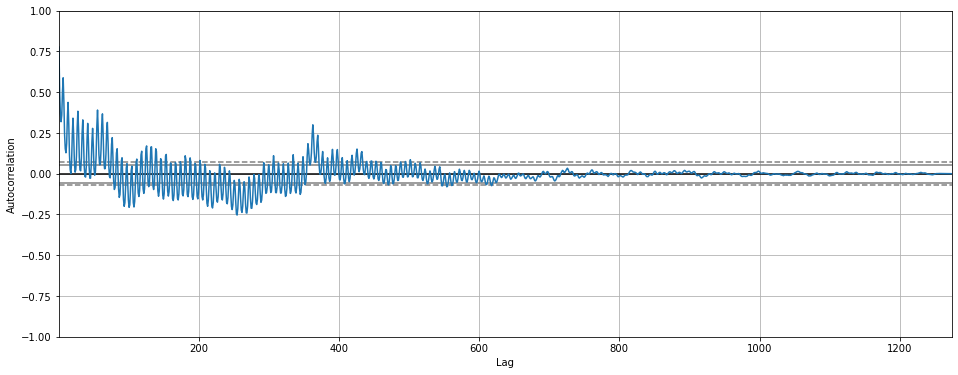

In [30]:
### Plot Auto-correclation ###
plt.figure(figsize=(16,6))
pd.plotting.autocorrelation_plot(train['SmoothedDataValue'])

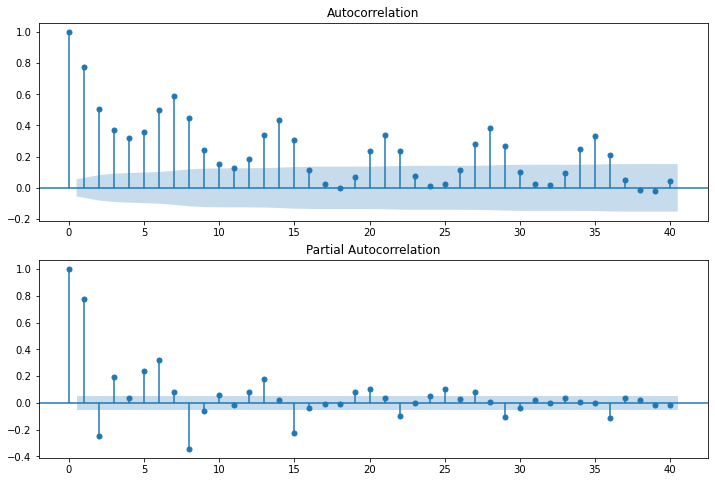

In [31]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(train['SmoothedDataValue'].dropna(),lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(train['SmoothedDataValue'].dropna(),lags=40,ax=ax2)

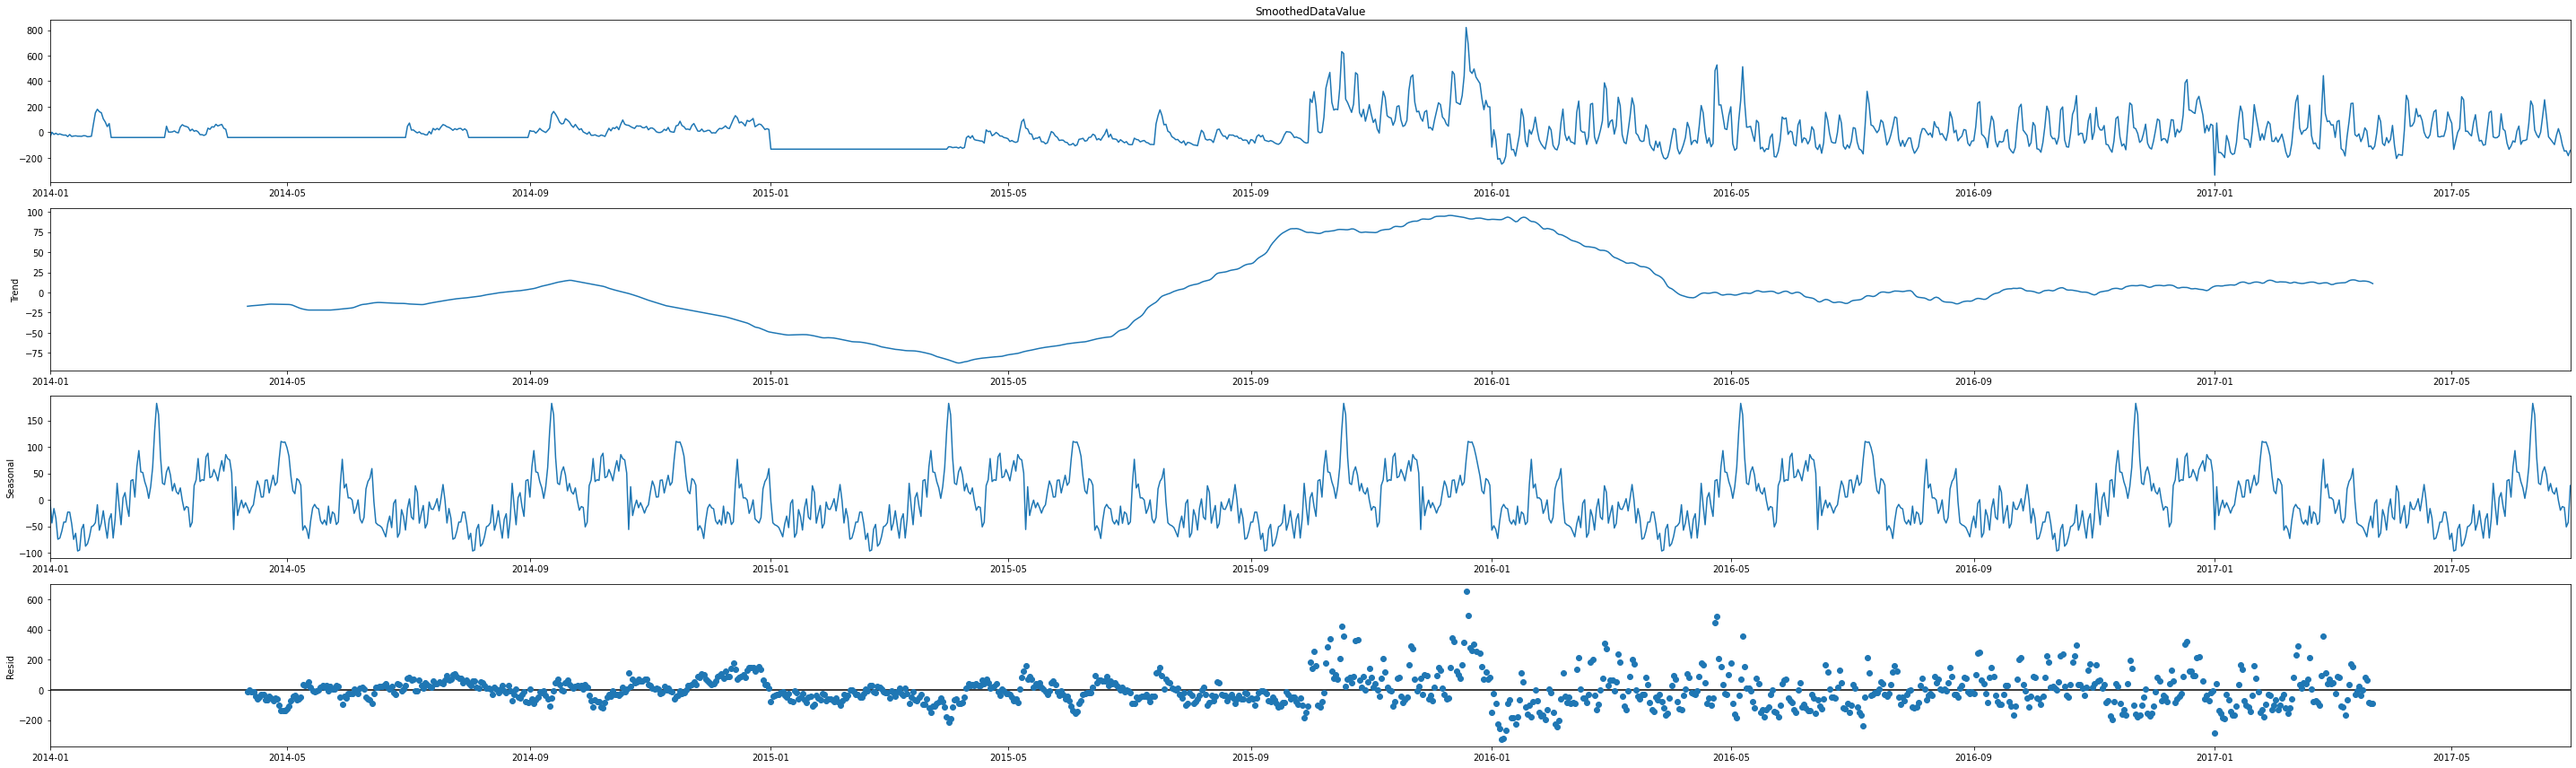

In [32]:
from pandas import Series
from matplotlib import pyplot
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(train['SmoothedDataValue'], model='additive', period=200)
result.plot()
pyplot.show()

<AxesSubplot:xlabel='date'>

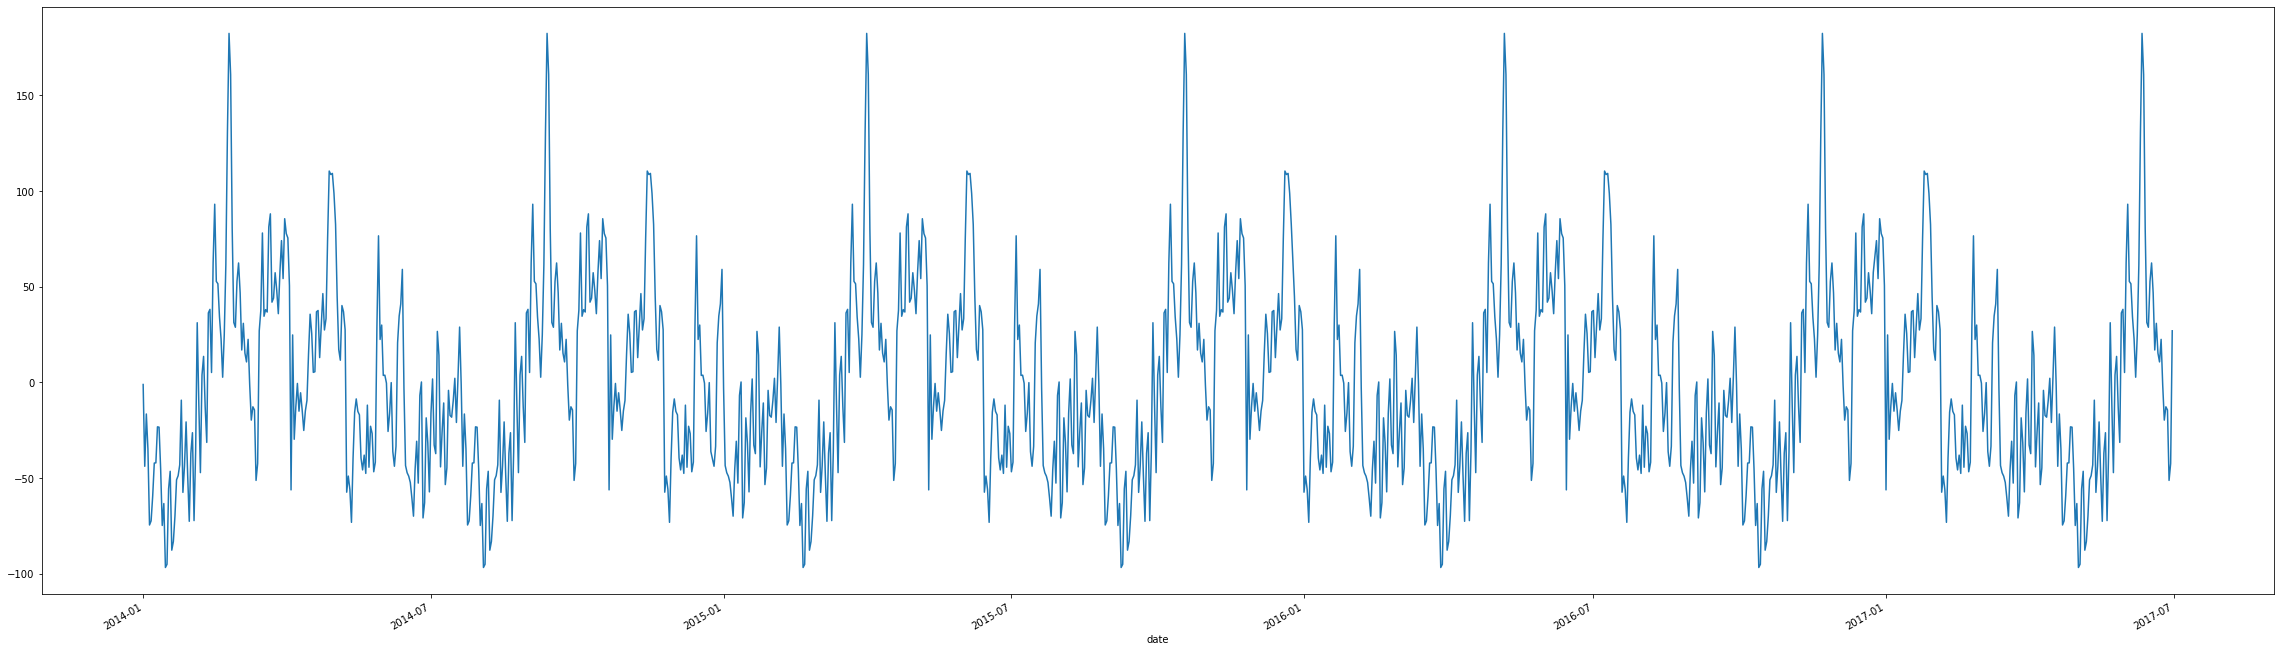

In [33]:
result.seasonal.plot()

<AxesSubplot:xlabel='date'>

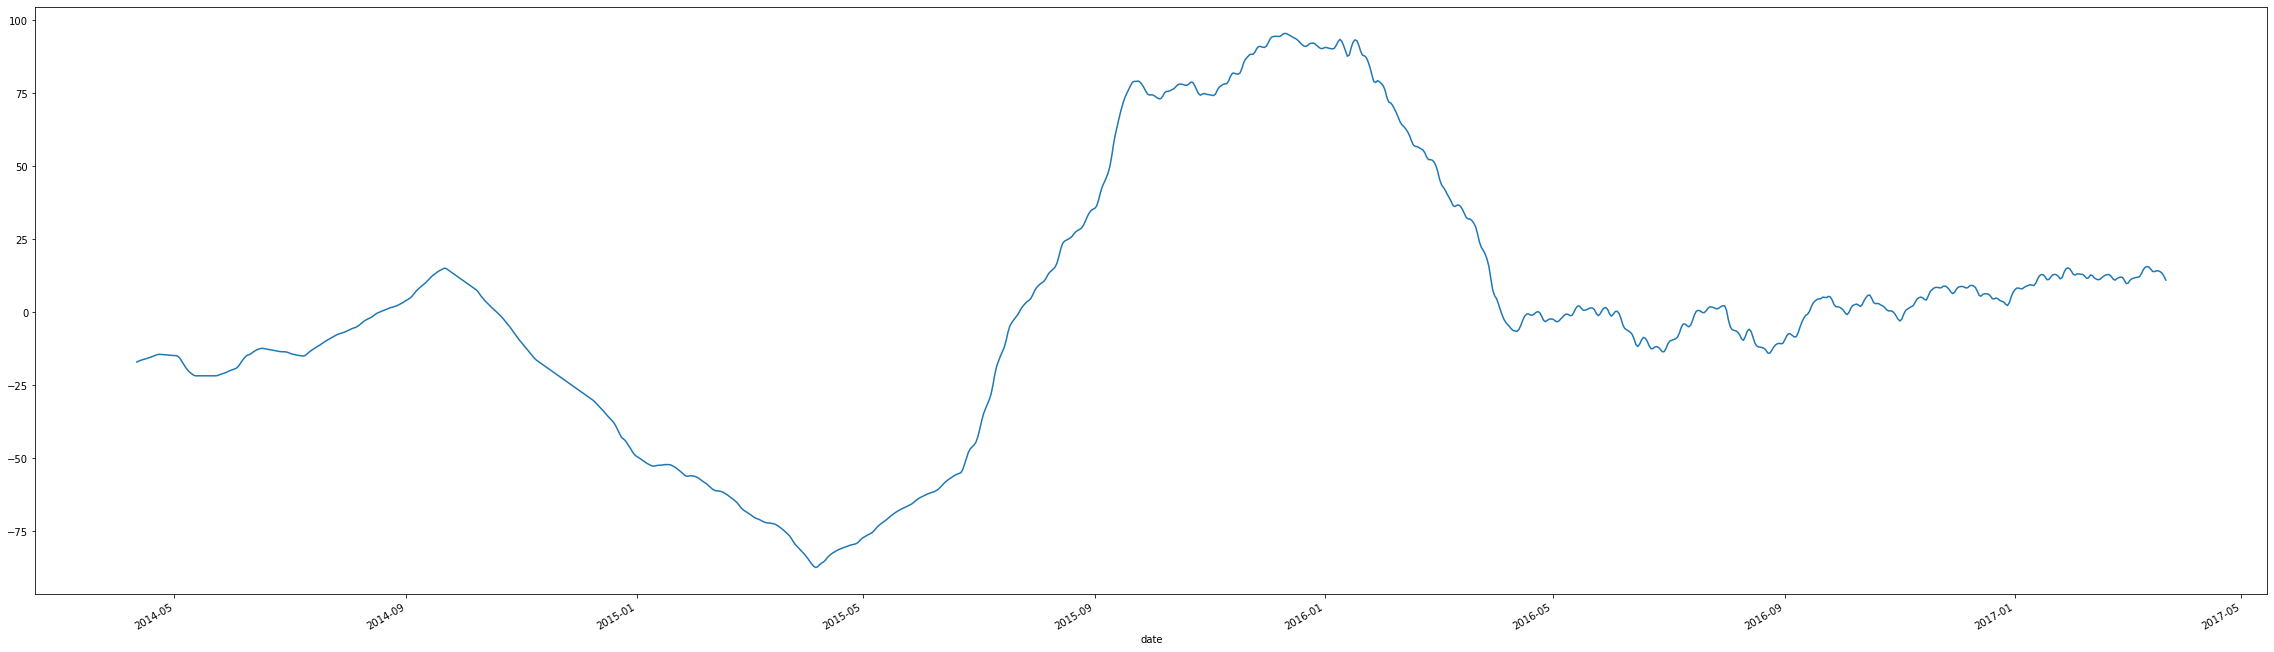

In [34]:
result.trend.plot()

# 8. Prepare Univariate Data for training

In [35]:
train_uni = train['SmoothedDataValue']

In [36]:
train_uni.head(5)

date
2014-01-01   -40.06044
2014-01-02    -0.06044
2014-01-03   -17.06044
2014-01-04    -8.06044
2014-01-05   -18.06044
Name: SmoothedDataValue, dtype: float64

In [37]:
test_uni = test['SmoothedDataValue']

In [38]:
test_uni.head(5)

date
2017-07-01    250.93956
2017-07-02    217.93956
2017-07-03    125.93956
2017-07-04    117.93956
2017-07-05    118.93956
Name: SmoothedDataValue, dtype: float64

# 9. ARIMA Model
- Find the best order of ARIMA model by grid search

In [39]:
### FIND BEST UNIVARIATE MODEL ###

AIC = {}
best_aic, best_order = np.inf, 0

# evaluate parameters
p_values = [5, 10, 15]
d_values = range(0, 5)
q_values = range(0, 5)

for p in p_values:
    for d in d_values:
        for q in q_values:
            mod = SARIMAX(train_uni, order=(p,d,q))
            try:
                res = mod.fit(disp=False)
                AIC[(p,d,q)] = res.aic
            except:
                AIC[(p,d,q)] = np.inf
            
            if AIC[(p,d,q)] < best_aic:
                best_aic = AIC[(p,d,q)]
                best_order = (p,d,q)
            
print('BEST ORDER', best_order, 'BEST AIC:', best_aic)

BEST ORDER (15, 0, 4) BEST AIC: 14041.397208844151


In [40]:
mod = SARIMAX(train_uni, order=best_order)
res = mod.fit(disp=False)
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:      SmoothedDataValue   No. Observations:                 1274
Model:              SARIMAX(15, 0, 4)   Log Likelihood               -7000.699
Date:                Sat, 13 Nov 2021   AIC                          14041.397
Time:                        19:04:16   BIC                          14144.396
Sample:                             0   HQIC                         14080.081
                               - 1274                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1215      0.089     12.594      0.000       0.947       1.296
ar.L2         -1.0673      0.161     -6.620      0.000      -1.383      -0.751
ar.L3          0.8721      0.181      4.812      0.0

# 10. In Sample Prediction

Get Prediction for the training set

In [41]:
InSample_predict = res.get_prediction()

Calculate RMSE Loss

In [42]:
# RMSE Loss
from statsmodels.tools.eval_measures import rmse
error=rmse(InSample_predict.predicted_mean, train_uni)

In [43]:
error

58.78979221749698

Calculate MAPE Loss

In [44]:
def percentage_error(actual, predicted):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / (actual[j])
        else:
            res[j] = predicted[j] / (np.mean(actual))
    return res

In [45]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs(percentage_error(np.asarray(y_true), np.asarray(y_pred)))) * 100

In [46]:
ins_y_pred = InSample_predict.predicted_mean.to_numpy()
ins_y_true = train_uni.to_numpy()

ins_mape = mean_absolute_percentage_error(ins_y_true, ins_y_pred)

In [47]:
ins_mape

206.7262395765843

Plot in-sample prediction

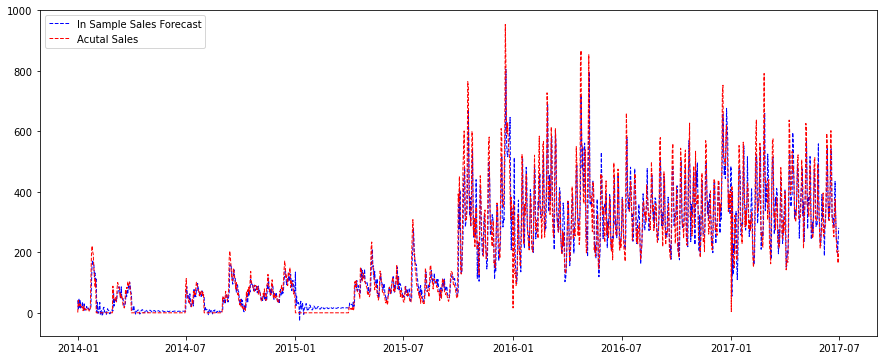

In [48]:
plt.figure(figsize=(15, 6))
plt.plot(InSample_predict.predicted_mean+train['SeasonMean'], linestyle='--', linewidth=1, color='blue', label='In Sample Sales Forecast')
plt.plot(df_train_mag_sales, linestyle='--', linewidth=1, color='red', label='Acutal Sales')
plt.legend(loc='upper left')

# 11. Out Sample Prediction

Pointwise prediction for the future 45 days right after the training set

In [49]:
from datetime import datetime
import statistics

mape_score = []
mape_mean = []
mape_list = []

point_forecast = res.get_prediction(end=mod.nobs)

OutSample_predict = {point_forecast.predicted_mean.index[0]: point_forecast.predicted_mean[point_forecast.predicted_mean.index[0]]}

for t, v in test_uni[:-1].iteritems():
    
     row = pd.Series(v, index=[t])
     res = res.extend(row.to_numpy())
     point_forecast = res.get_prediction()
     OutSample_predict[t.date()] = point_forecast.predicted_mean.values[0]
    
     # Calculate MAPE Loss
     mape_score.append(abs((test_uni[t]-point_forecast.predicted_mean.values[0])/test_uni[t])*100)
     mape_mean = statistics.mean(mape_score)
     mape_list.append(mape_mean)

In [50]:
mape_list

[114.6095153139509,
 65.90879485239554,
 62.522383581751065,
 59.273613490690096,
 55.70176116717219,
 57.224454050695094,
 53.13071912951378,
 49.128147798626145,
 44.54917683449149,
 41.6483208553487,
 38.56316696187926,
 36.62092164519777,
 33.86249809016533,
 32.31308558371822,
 30.2767561289923,
 29.379329763319884,
 27.811370768444746,
 26.580861563163474,
 26.925398738968966,
 26.688765994495704,
 26.099080151761846,
 25.651376457528915,
 24.617103544924095,
 23.876284813603323,
 23.692448559286245,
 23.06376917560764,
 22.505343828000026,
 21.89722676349199,
 21.437494387661193,
 21.075916392710354,
 20.690371820396994,
 21.505062849814223,
 20.93528976106009,
 21.775068949870803,
 21.911411255434135,
 22.217793090819747,
 22.096225482472466,
 22.291636864825033,
 21.77647566635596,
 21.85865882664157,
 21.587821551319827,
 21.644735794258505,
 21.439689860940863,
 21.38739276038675,
 21.45357521880623]

In [59]:
round(sum(mape_list)/len(mape_list))

33

Preprocess the prediction result dataframe by excluding the first element from the dict which used to initialize the pointwise prediction in previous steps

In [51]:
df_OutSample_predict = pd.DataFrame(columns = ['date','sales'])

counter = 0

for k, v in OutSample_predict.items():
    if counter > 0:
        df_OutSample_predict.loc[counter-1] = [k, v]
    counter += 1

Calculate RMSE Loss

In [52]:
# RMSE Loss
error=rmse(df_OutSample_predict['sales'], test_uni[1:])

In [53]:
error

115.29640703209527

Plot out-sample prediction

In [54]:
#Add back the season mean for the visualization of actual

df_OutSample_predict['SeasonMean'] = test['SeasonMean'][1:].to_numpy()
df_OutSample_predict['actual_sales'] = df_OutSample_predict['sales'] + df_OutSample_predict['SeasonMean']

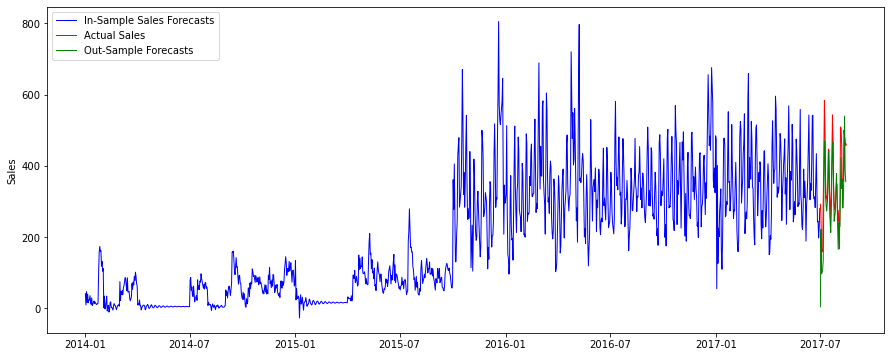

In [55]:
plt.figure(figsize=(15, 6))
plt.ylabel('Sales')
plt.plot(InSample_predict.predicted_mean+train['SeasonMean'], linestyle='-', linewidth=1, color='blue', label='In-Sample Sales Forecasts')
plt.plot(df_test_mag_sales.index, df_test_mag_sales['sales'], linestyle='-', linewidth=1, color='red', label='Actual Sales')
plt.plot(df_OutSample_predict['date'], df_OutSample_predict['actual_sales'], linestyle='-', linewidth=1, color='green', label='Out-Sample Forecasts')
plt.legend(loc='upper left');

# 12. Model Evaluation - Plot MAPE Loss Analysis

Loss Analysis of out-sample forecast

[]

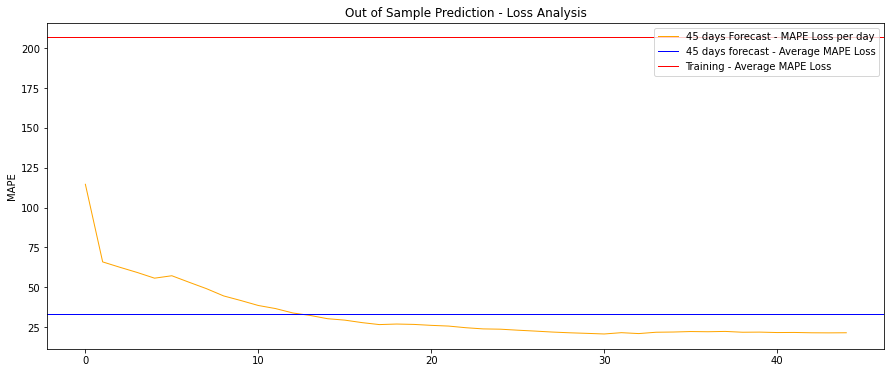

In [57]:
plt.figure(figsize=(15, 6))
plt.title('Out of Sample Prediction - Loss Analysis')
plt.ylabel('MAPE')

plt.plot(mape_list, linestyle='-', linewidth=1, color='orange', label='45 days Forecast - MAPE Loss per day')
plt.axhline(y=round(sum(mape_list)/len(mape_list)), linestyle='-', linewidth=1, color='blue', label='45 days forecast - Average MAPE Loss')
plt.axhline(y=ins_mape, linestyle='-', linewidth=1, color='red', label='Training - Average MAPE Loss')

plt.legend(loc='upper right')
plt.plot()